In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [3]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169694 sha256=c96b0dde4508a9b1c039e0e6651a705330e0e43025edb354f70cf679a2f92b8b
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [4]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [5]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

In [7]:
#DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [8]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir('/content/drive/My Drive/annotations') if f.endswith(".xml")]:
  tree = ET.parse(os.path.join('/content/drive/My Drive/annotations', xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join('/content/drive/My Drive/images', elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

In [9]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/resnet50_csv_10.h5'
#shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [10]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

Using TensorFlow backend.
2020-06-19 21:08:13.466057: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-06-19 21:09:49.059173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-19 21:09:49.111190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-19 21:09:49.111774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-06-19 21:09:49.111830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart

In [12]:
THRES_SCORE = 0.8

In [20]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
import tensorflow.python.keras.backend as K
K.get_session()
#keras.backend.tensorflow_backend.set_session(get_session())

In [21]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [

In [22]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving test_00004931.jpg to test_00004931.jpg
Running inference on: test_00004931.jpg
processing time:  3.5461440086364746


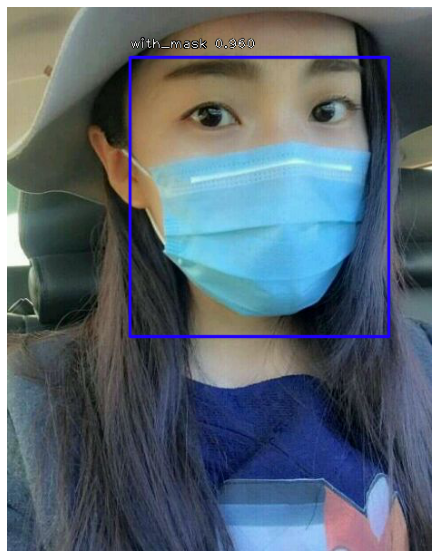

In [23]:

uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)